<a href="https://colab.research.google.com/github/Zerldas/Translate-EN-to-FR-Project/blob/main/NLP_Project_Translate_EN_to_FR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!python3 --version

Python 3.12.12


**Kiểm tra và tải về các thư viện cần thiết trước khi thực hiện project**

In [3]:
# Tải về các thư viện cần thiết trước khi thực hiện project
!pip list

Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.9
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget                          

In [4]:
!pip install spacy

!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 67.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


***Danh sách các thư viện sẽ được sử dụng***

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
from wordcloud import WordCloud
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

Thiết lập GPU

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

Device: cpu


Thiết lại tokenizer

In [16]:
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("de_core_news_sm")

In [17]:
# Tokenizer
def tokenizer_en(sentences):
  return[token.sentences.lower() for token in nlp_en(text) if token.text.strip()]

def tokenizer_fr(sentences):
  return[token.sentences.lower() for token in nlp_fr(text) if token.text.strip()]

***Tiến hành phân tích dữ liệu***

In [9]:
# Khai báo dường đẫn dữ liệu train
train_en_path = "/content/drive/MyDrive/EN-FR/data/train/train.en"
train_fr_path = "/content/drive/MyDrive/EN-FR/data/train/train.fr"
# Dữ liệu valiation
val_en_path = "/content/drive/MyDrive/EN-FR/data/val/val.en"
val_fr_path = "/content/drive/MyDrive/EN-FR/data/val/val.fr"
# Dữ liệu test sử dụng tạp test 2016 flick
test_en_path = "/content/drive/MyDrive/EN-FR/data/test/test_2016_flickr.en"
test_fr_path = "/content/drive/MyDrive/EN-FR/data/test/test_2016_flickr.fr"

In [10]:
def load_data(en_path, fr_path):
    with open(en_path, encoding="utf-8") as f_en:
        en_lines = [line.strip() for line in f_en]

    with open(fr_path, encoding="utf-8") as f_fr:
        fr_lines = [line.strip() for line in f_fr]

    assert len(en_lines) == len(fr_lines), "EN-FR line count mismatch!"
    return en_lines, fr_lines

In [12]:
train_en_lines, train_fr_lines = load_data(train_en_path, train_fr_path)
val_en_lines, val_fr_lines = load_data(val_en_path, val_fr_path)
test_en_lines, test_fr_lines = load_data(test_en_path, test_fr_path)

print("=== TẬP TRAIN ===")
print(f"Tiếng Anh: {len(train_en_lines)}")
print(f"Tiếng Pháp: {len(train_fr_lines)}")
print(f"Tổng: {len(train_en_lines) + len(train_fr_lines)}\n")

print("=== TẬP VALIDATION ===")
print(f"Tiếng Anh: {len(val_en_lines)}")
print(f"Tiếng Pháp: {len(val_fr_lines)}")
print(f"Tổng: {len(val_en_lines) + len(val_fr_lines)}\n")

print("=== TẬP TEST ===")
print(f"Tiếng Anh: {len(test_en_lines)}")
print(f"Tiếng Pháp: {len(test_fr_lines)}")
print(f"Tổng: {len(test_en_lines) + len(test_fr_lines)}")

=== TẬP TRAIN ===
Tiếng Anh: 29000
Tiếng Pháp: 29000
Tổng: 58000

=== TẬP VALIDATION ===
Tiếng Anh: 1014
Tiếng Pháp: 1014
Tổng: 2028

=== TẬP TEST ===
Tiếng Anh: 1000
Tiếng Pháp: 1000
Tổng: 2000


In [19]:
# Xem xét độ dài câu (token)
def get_lengths(sentences, tokenizer):
    return [len(tokenizer(s)) for s in sentences]

train_len_en = get_lengths(train_en_lines, tokenize_en)
train_len_fr = get_lengths(train_fr_lines, tokenize_fr)

print(train_len_en)
print(train_len_fr)

[11, 12, 9, 15, 9, 15, 8, 14, 12, 11, 10, 16, 9, 16, 8, 17, 13, 15, 10, 16, 12, 17, 9, 11, 16, 22, 10, 12, 9, 16, 11, 11, 8, 16, 10, 22, 10, 19, 6, 21, 8, 13, 8, 12, 10, 15, 11, 17, 14, 16, 15, 20, 8, 20, 8, 18, 11, 21, 7, 11, 11, 15, 12, 12, 14, 17, 8, 17, 12, 15, 12, 9, 9, 17, 16, 18, 12, 14, 8, 12, 10, 12, 10, 16, 8, 13, 8, 20, 10, 13, 16, 11, 18, 15, 10, 19, 10, 19, 13, 19, 12, 13, 9, 14, 13, 20, 10, 13, 10, 13, 14, 16, 12, 11, 8, 13, 10, 17, 10, 11, 14, 19, 14, 9, 13, 14, 8, 17, 8, 19, 18, 14, 15, 19, 12, 23, 11, 16, 14, 22, 13, 17, 8, 18, 8, 14, 9, 11, 10, 11, 9, 13, 10, 10, 8, 13, 10, 14, 12, 20, 10, 16, 13, 8, 11, 12, 10, 12, 16, 24, 15, 11, 10, 18, 11, 13, 13, 12, 11, 10, 13, 19, 10, 14, 8, 12, 9, 13, 10, 13, 8, 11, 9, 20, 13, 20, 21, 9, 7, 16, 12, 14, 10, 14, 10, 13, 11, 14, 11, 10, 9, 11, 10, 14, 9, 10, 11, 16, 10, 10, 10, 21, 9, 10, 8, 34, 8, 17, 12, 12, 15, 33, 13, 14, 11, 12, 9, 35, 13, 17, 8, 21, 10, 15, 10, 8, 8, 15, 7, 15, 13, 14, 11, 8, 10, 12, 10, 16, 11, 15, 7, 12, 

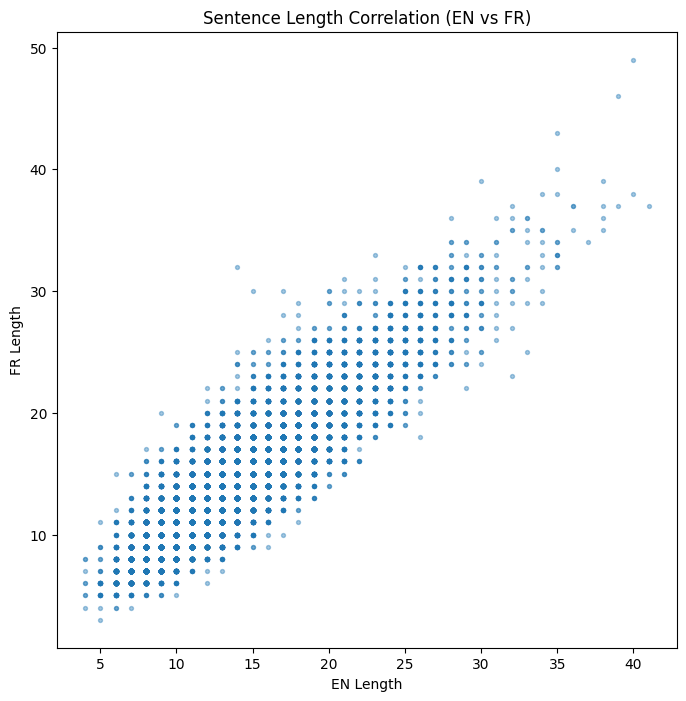

In [20]:
# Biểu đồ xem xét độ dài câu
plt.figure(figsize=(8,8))
plt.scatter(train_len_en, train_len_fr, s=8, alpha=0.4)
plt.xlabel("EN Length")
plt.ylabel("FR Length")
plt.title("Sentence Length Correlation (EN vs FR)")
plt.show()

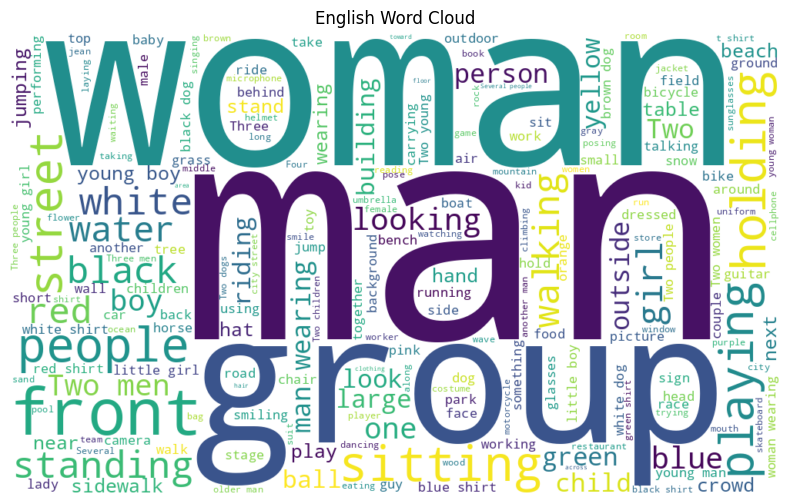

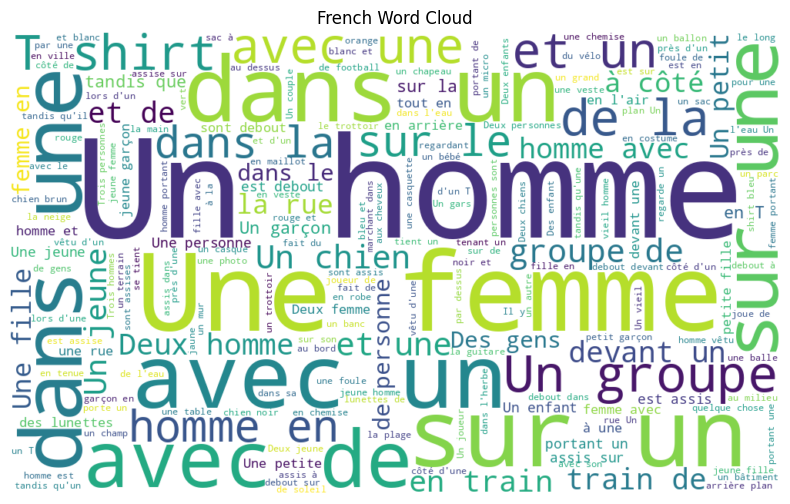

In [24]:
en_text = " ".join(train_en_lines)
fr_text = " ".join(train_fr_lines)

wordcloud_en = WordCloud(width=1000, height=600, background_color='white').generate(en_text)
wordcloud_fr = WordCloud(width=1000, height=600, background_color='white').generate(fr_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_en, interpolation='bilinear')
plt.axis("off")
plt.title("English Word Cloud")
plt.show()

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_fr, interpolation='bilinear')
plt.axis("off")
plt.title("French Word Cloud")
plt.show()

Xây dựng vocabulary

In [28]:
def build_vocab(sentences, tokenizer, max_size=10000000):
  counter = Counter()

  for sen in sentences:
    tokens = tokenizer(sen)
    counter.update(tokens)

  most_common = counter.most_common(max_size - 4)

  # Danh sách từ
  index_token = [
      "<pad>", #Padding giúp câu có cùng độ dài
      "<unk>", #Unknow đánh dấu từ không có nghĩa
      "<sos>", #Từ ở đầu câu
      "<eos>" #TỪ ở cuối câu
  ] + [word for word, _ in most_common]

  # map token → id
  token_to_index = {token: idx for idx, token in enumerate(index_token)}

  return token_to_index, index_token, counter

In [29]:
# Build vocab
vocab_en, index_en, counter_en = build_vocab(train_en_lines, tokenize_en, max_size=10000)
vocab_fr, index_fr, counter_fr = build_vocab(train_fr_lines, tokenize_fr, max_size=10000)

print("EN vocab size:", len(vocab_en))
print("FR vocab size:", len(vocab_fr))

KeyboardInterrupt: 

In [ ]:
# Đưa vocab về dạng số
def numericalize(sentence, tokenizer, vocab):
  tokens = ["<sos>"] + tokenizer(sentence) + ["<eos>"]
  return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

In [ ]:
class Translate_Dataset(torch.utils.data.Dataset):
  def __init__(self, en_sentences. fr_sentences):
    self.en = en_sentences
    self.fr = fr_sentences

  def __len__(self):
    return len(self.en)

  def __getitem__(self):
    src = numericalize(self.en, tokenizer_en, vocab_en)
    trg = numericalize(self.en, tokenizer_fr, vocab_fr)
    return src, trg

In [ ]:
# Chuẩn hóa dữ liệu trước khi đưa vào mô hình
def collate_fn(batch):
  src_batch, trg_batch = zip(*batch)

  src_lengths = [len(x) for x in src_batch]
  trg_lengths = [len(x) for x in trg_batch]

  #sort
  sorted_index = sorted(range(len(src_lengths)), key=lambda i: -src_lengths[i])
  src_batch = [src_batch[i] for i in sorted_idx]
  trg_batch = [trg_batch[i] for i in sorted_idx]
  src_lengths = [src_lengths[i] for i in sorted_idx]
  trg_lengths = [trg_lengths[i] for i in sorted_idx]

  src_batch = pad_sequence(src_batch, padding_value=PAD, batch_first=True)
  trg_batch = pad_sequence(trg_batch, padding_value=PAD, batch_first=True)

  return src_batch, trg_batch, src_lengths


In [ ]:
# Tạo DataLoaders
train = Translate_Dataset(train_en, train_fr)
val = Translate_Dataset(val_en, val_fr)
test = Translate_dataset(test_en, test_fr)

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)

  def forward(self, src, lengths):
    x = self.embedding(src)
    packed = nn.utils.rnn.pack_padded_sequence(embedded, src_len,
                                                   batch_first=True, enforce_sorted=True)
    outputs, (hidden, cell) = self.lstm(packed)
    return hidden, cell

Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, vocab_size)

    def forward(self, token, hidden, cell):
        token = token.unsqueeze(1)
        embedded = self.embedding(token)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

Seq2Seq

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec

    def forward(self, src, trg, src_len, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.size()
        vocab_size = self.dec.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(src.device)

        hidden, cell = self.enc(src, src_len)

        input_token = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.dec(input_token, hidden, cell)
            outputs[:, t] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input_token = trg[:, t] if teacher_force else top1

        return outputs

Build Model

In [ ]:
# Khai báo thông số model
INPUT_SIZE = len(vocab_en)
OUTPUT_SIZE = len(vocab_de)
ENC_EMB_SIZE = 256
DEC_EMB_SIZE = 256
HID_DIM = 512
BATCH_SIZE = 32
N_EPOCHS = 10
LEARNING_RATE = 0.001

In [ ]:
encoder = Encoder(INPUT_SIZE, ENC_EMB_SIZE, HID_SIZE).to(DEVICE)
decoder = Decoder(OUTPUT_SIZE, DEC_EMB_SIZE, HID_SIZE).to(DEVICE)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training Loop

In [ ]:
def train_epoch():
    model.train()
    total_loss = 0

    for src, trg, src_len in train_loader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)

        optimizer.zero_grad()
        output = model(src, trg, src_len)

        output_reshaped = output[:, 1:].reshape(-1, output.size(-1))
        trg_reshaped = trg[:, 1:].reshape(-1)

        loss = criterion(output_reshaped, trg_reshaped)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


In [ ]:
# Tính Valid
def eval_epoch():
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, trg, src_len in val_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, src_len, teacher_force=0.0)

            output_reshaped = output[:, 1:].reshape(-1, output.size(-1))
            trg_reshaped = trg[:, 1:].reshape(-1)

            loss = criterion(output_reshaped, trg_reshaped)
            total_loss += loss.item()

    return total_loss / len(val_loader)

In [ ]:
# Train model
for epoch in range(10):
    train_loss = train_epoch()
    val_loss = eval_epoch()
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

In [ ]:
# Hàm translate
def translate(sentence):
    model.eval()
    src = numericalize(sentence, tok_en, vocab_en).unsqueeze(0).to(device)
    src_len = [src.size(1)]

    hidden, cell = model.enc(src, src_len)

    token = torch.tensor([SOS], device=device)
    result = []

    for _ in range(50):
        out, hidden, cell = model.dec(token, hidden, cell)
        token = out.argmax(1)
        if token.item() == EOS:
            break
        result.append(idx_to_fr[token.item()])

    return " ".join(result)

In [ ]:
# Hàm tính BLEU
def compute_bleu(n=100):
    scores = []
    for i in range(n):
        pred = translate(test_en[i])
        ref = tok_fr(test_fr[i])
        scores.append(sentence_bleu([ref], pred.split()))
    return sum(scores) / len(scores)

print("BLEU:", compute_bleu(100))